In [1]:
import pandas as pd
import re
from itertools import combinations_with_replacement, combinations
from collections import Counter
import matplotlib
import numpy as np
import plotly.graph_objects as go
from multiprocessing import Pool
from functions5 import *
from analysis_functions import *

## Geotagged US Map of all locations
############################

Take in dataframe of posts, convert to dataframe of state to size, produce temporal heatmap by filtering on date.

In [6]:
df = pd.read_csv("Processed_Data/state_tagged.csv")
shorts = pd.read_pickle("shorts.pkl")
shorts = shorts[shorts.short_code.isin(df.short_code)]
df = df[["state", "short_code"]]
shorts = shorts[["short_code", "time"]]
df = pd.merge(df, shorts)
df = df[~df.state.isna()]
df.time = pd.to_datetime(df.time, unit="s")
df = df[df.time >"2020-05-01"]

In [21]:
df.state.value_counts() / 155282 

CA    0.210617
NY    0.151189
MN    0.096180
TX    0.065764
FL    0.048306
DC    0.042329
GA    0.041898
IL    0.030293
PA    0.030171
OR    0.019758
NC    0.019474
NJ    0.018965
CO    0.018315
VA    0.017620
MA    0.017143
WA    0.014599
OH    0.013318
MI    0.012081
NV    0.012075
MD    0.012017
AZ    0.011424
TN    0.010336
WI    0.008604
LA    0.008423
CT    0.007019
KY    0.005899
MO    0.005558
IN    0.005513
SC    0.005493
AL    0.004585
UT    0.003709
HI    0.003478
OK    0.003284
RI    0.002917
AR    0.002235
NM    0.002080
IA    0.001919
NH    0.001848
ME    0.001803
NE    0.001668
KS    0.001507
DE    0.001443
ID    0.001378
MS    0.001211
MT    0.000934
AK    0.000792
WV    0.000689
VT    0.000683
ND    0.000592
SD    0.000535
WY    0.000328
Name: state, dtype: float64

In [3]:
df2 = df.state.value_counts()
df2 = pd.DataFrame( df2 ).reset_index()
df2.columns = ["code", "posts"]

In [4]:
fig = go.Figure(data=go.Choropleth(
    locations=df2['code'], # Spatial coordinates
    z = df2['posts'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "# of Posts",
    showscale = False,
    zmin=0,
    zmax=100
))

fig.update_layout(
    title_text = 'BLM2020: Total Participation',
    geo_scope='usa', # limite map scope to USA
)

#     fig.show()
fig.write_image("figures/Total_Participation.jpeg")

In [5]:
dates = pd.date_range("2020-05-25", "2020-06-25", freq = "H")

In [ ]:
%%time
for i,d in enumerate(dates[:-1]):
    df1 = df[ (df.time > d) & (df.time < dates[i+1])].state.value_counts()
    df1 = pd.DataFrame( df1 ).reset_index()
    df1.columns = ["code", "posts"]
    
    fig = go.Figure(data=go.Choropleth(
        locations=df1['code'], # Spatial coordinates
        z = df1['posts'].astype(float), # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Blues',
         
        
        colorbar_title = "# of Posts",
        showscale = False,
        zmin=0,
        zmax=100
    ))

    fig.update_layout(
        title_text = 'BLM2020: {}'.format(d),
        geo_scope='usa', # limite map scope to USA
    )

    fig.write_image("figures/animation_1stDerivative/{}.jpeg".format(i))

## Hashtag Co-occurence and network

In [ ]:
df = pd.read_pickle("shorts.pkl")
df = df[df.text.apply(lambda x: isinstance(x,str))]

In [3]:
%%time
get_hashtags = lambda x: re.findall(r"#(\w+)", x)
df["hashtags"] = df.text.apply(get_hashtags)
hashtag_counts = Counter([item.lower() for sublist in df.hashtags.values for item in sublist])
hashtag_counts = pd.DataFrame([[k,v] for k,v in hashtag_counts.items()], columns = ["hashtag", "counts"])
hashtag_counts.sort_values("counts", ascending=False,inplace=True)

Wall time: 9.44 s


In [ ]:
%%time
df.hashtags = df.hashtags.apply(sorted)

In [9]:
%%time
if __name__ == "__main__":
    n_cores = 24
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    counters = pool.map(get_hash_oneshot, df_split)
    pool.close()
    pool.join()

Wall time: 23 s


In [106]:
%%time
hashtag_dict = Counter()
for c in counters:
    hashtag_dict += c
hashtag_dict = pd.DataFrame([[k[0],k[1],v] for k,v in hashtag_dict.items()], columns = ["hash1", "hash2","counts"])
hashtag_dict.sort_values("counts", ascending = False, inplace = True)

Wall time: 54.2 s


## Temporal behavior of hashtags

In [5]:
%%time
df = pd.read_pickle("shorts.pkl")
df = df[df.text.apply(lambda x: isinstance(x,str))]
get_hashtags = lambda x: re.findall(r"#(\w+)", x)
df["hashtags"] = df.text.apply(get_hashtags)
df.hashtags = df.hashtags.apply(sorted)

df["datetime"] = pd.to_datetime(df.time, errors = "coerce",unit = "s")
df = df[~ df.datetime.isna() ]
df = df[df.datetime >"2020-05-25"]
df = df[df.datetime <"2020-06-25"]
df["time"] = df.datetime.dt.time
df["date"] = df.datetime.dt.round("2H")

Wall time: 12.5 s


In [6]:
df["date"] = df.datetime.dt.round("12H")
top = hashtag_counts[:7].hashtag.values

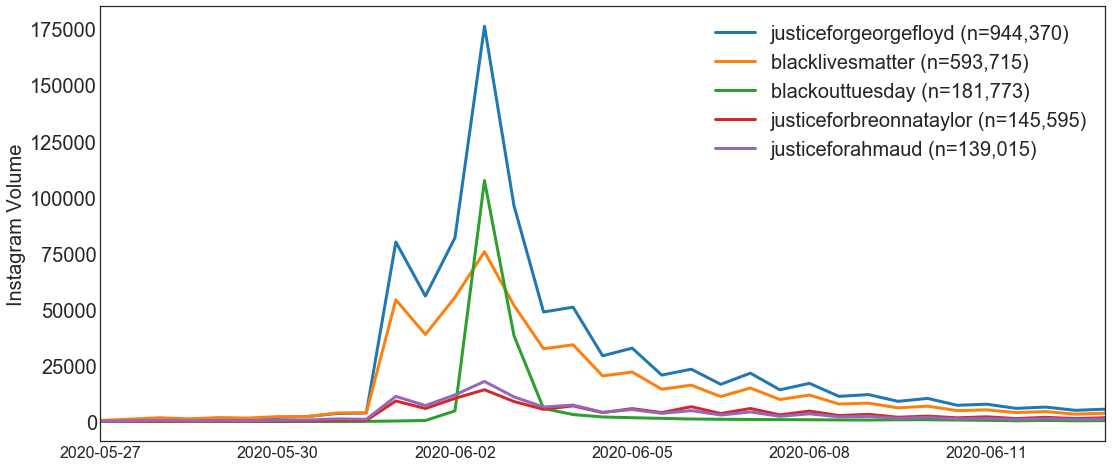

In [10]:
# %%time
plt.figure(figsize=(18,8))
xpoints = pd.date_range("2020-05-27", "2020-06-13",freq="3D")
for i,HT in enumerate(top):
    if (i == 2) or (i==3):
        continue
    sub_df = df[ df.hashtags.apply(lambda x: HT in x) ]
    sub_df = sub_df.date.value_counts()
    sub_df.sort_index(inplace=True)
    plt.plot(sub_df.index, sub_df.values, label = "{} (n={:,})".format(HT, sub_df.values.sum()), linewidth=3)
    
plt.yticks(fontsize=20)
plt.ylabel("Instagram Volume", fontsize=20)
plt.xticks(xpoints, fontsize=16)
plt.xlim(pd.Timestamp("2020-05-27 00:00:00"), pd.Timestamp("2020-06-13 00:00:00"))
plt.legend(fontsize=20)


# plt.savefig("Timeseries.png")

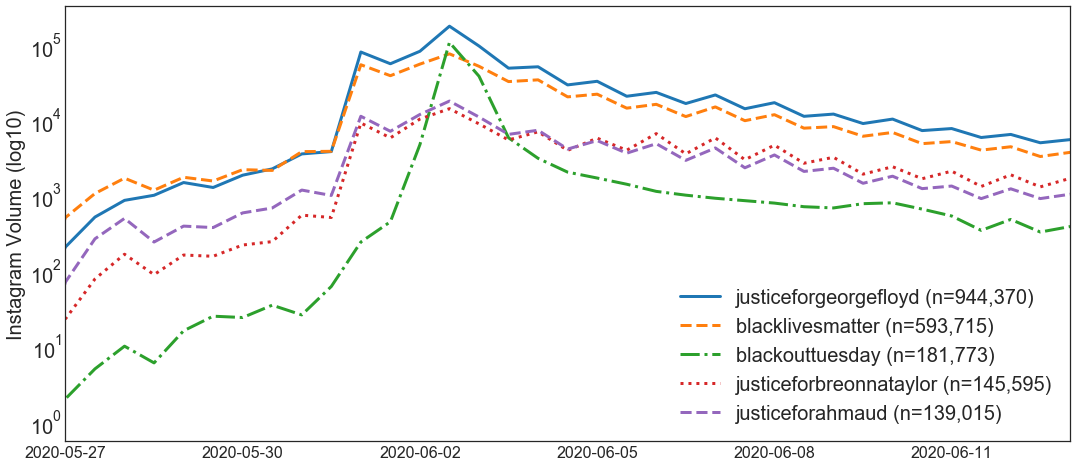

In [11]:
plt.figure(figsize=(18,8))
linestyles = ["-", "--", "-.", ":", "--"]
adjustedHashes = ["#JusticeForGeorgeFloyd", "#BlackLivesMatter"]
linecounter= 0



for i,HT in enumerate(top):
    if (i == 2) or (i==3):
        continue
    sub_df = df[ df.hashtags.apply(lambda x: HT in x) ]
    sub_df = sub_df.date.value_counts()
    sub_df.sort_index(inplace=True)
    plt.plot(sub_df.index, sub_df.values, 
             label = "{} (n={:,})".format(HT, sub_df.values.sum()), 
             linewidth=3, linestyle=linestyles[linecounter])
    linecounter += 1
    
plt.yticks(fontsize=20)
plt.ylabel("Instagram Volume (log10)", fontsize=20)
plt.xticks(xpoints, fontsize=16)
plt.xlim(pd.Timestamp("2020-05-27 00:00:00"), pd.Timestamp("2020-06-13 00:00:00"))
plt.legend(fontsize=20)
plt.yscale("log")
plt.savefig("Timeseries-log.png")